# <center><span style='background:yellow'> Détectez les Bad Buzz grâce au Deep Learning</span></center>
## <center><span style='background:yellow'>Modèle de Deep Learning avec BERT</span></center> 
===================================================================================================================

## Sommaire <a class="anchor" id="sommaire"></a>

* [Import des librairies, chargement des données](#00)
* [1. Nettoyage avec lemmatisation et vectorisation avec Word2Vec](#10)  
* [2. Nettoyage avec lemmatisation et vectorisation avec Glove](#20)  
* [3. Nettoyage avec Stemming et vectorisation avec Word2Vec](#30)  
* [4. Nettoyage avec Stemming et vectorisation avec Glove](#40)  

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import des librairies, chargement des données<a class="anchor" id="00"></a>

In [ ]:
!pip install tensorflow==2.9

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 511.7 MB 172 bytes/s 
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.9.2
    Uninstalling tensorflow-2.9.2:
      Successfully uninstalled tensorflow-2.9.2


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 4.6 MB/s 
     |████████████████████████████████| 7.6 MB 96.8 MB/s 
     |████████████████████████████████| 182 kB 93.7 MB/s 


In [ ]:
# Chargement des données
path = '/content/drive/MyDrive/p7/'

In [ ]:
import pandas as pd
train = pd.read_csv(path + 'data/train.csv', index_col=0, encoding='utf-8')
validation = pd.read_csv(path + 'data/validation.csv', index_col=0, encoding='utf-8')
test = pd.read_csv(path + 'data/test.csv', index_col=0, encoding='utf-8')


train.dropna(inplace=True)
validation.dropna(inplace=True)
test.dropna(inplace=True)

In [ ]:
train.head()

,tweet,label,tweet_clean_lemm,tweet_clean_stem
1273151,#Goodsex When he makes you squirt all over him,1,goodsex make squirt,goodsex make squirt
445145,Looking for a &quot;Sexy Sailors&quot; outfit ...,0,look quot;sexy sailors&quot outfit laura hen n...,look quot;sexi sailors&quot outfit laura hen n...
499993,i dont know why twitter just now sent that thr...,0,not know twitter send word headache,nt know twitter sent word headach
122529,A particularly brutal rejection has put me off...,0,particularly brutal rejection writing never co...,particular brutal reject write never consid eg...
1322335,@bets_carabuena dear! sa friday pa dito thurs...,1,dear sa friday pa dito thursday ang game,dear sa friday pa dito thursday ang game


In [ ]:
from transformers import AutoTokenizer
from tqdm import tqdm
import numpy as np
BERT_MODEL = "bert-base-uncased" 
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL, do_lower_case=True)
def bert_encode(sequences, tokenize = tokenizer):
   # "vinai/bertweet-base"
  MAX_LENGTH = 200

  input_ids = np.asarray(
     [
        tokenizer(sent, max_length=MAX_LENGTH, padding="max_length", truncation=True)[
            "input_ids"
        ]
        for sent in tqdm(sequences)
     ]
  )
  attention_mask = np.asarray(
    [
        tokenizer(sent, max_length=MAX_LENGTH, padding="max_length", truncation=True)[
            "attention_mask"
        ]
        for sent in tqdm(sequences)
    ]
  )
  token_type_ids = np.asarray(
    [
        tokenizer(sent, max_length=MAX_LENGTH, padding="max_length", truncation=True)[
            "token_type_ids"
        ]
        for sent in tqdm(sequences)
    ]
  )
  return input_ids, attention_mask, token_type_ids

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
input_ids_train, attention_mask_train, token_type_ids_train = bert_encode(train.tweet_clean_lemm)

100%|██████████| 625617/625617 [01:06<00:00, 9357.82it/s]


In [ ]:
input_ids_val, attention_mask_val, token_type_ids_val = bert_encode(validation.tweet_clean_lemm)

100%|██████████| 268092/268092 [00:27<00:00, 9736.30it/s] 


In [ ]:
input_ids_test, attention_mask_test, token_type_ids_test = bert_encode(test.tweet_clean_lemm)

100%|██████████| 99333/99333 [00:10<00:00, 9758.05it/s] 


In [ ]:
from transformers import TFAutoModelForSequenceClassification
from keras.callbacks import EarlyStopping
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy

# Define NN model
print("Defining model...")
model = TFAutoModelForSequenceClassification.from_pretrained(BERT_MODEL, num_labels=2)

# compile NN network
print("Compiling model...")
model.compile(
    loss=BinaryCrossentropy(),
    optimizer=Adam(learning_rate=2e-5),  # Value recommended by the Bert team
    metrics=BinaryAccuracy(),
)
model.bert.trainable = False
print(model.summary())

Defining model...


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Compiling model...
Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 1,538
Non-trainable params: 109,482,240
_________________________________________________________________
None


In [ ]:
from time import time 

t0 = time()
learning_time = {}
print("Fitting model...")
history = model.fit([input_ids_train, attention_mask_train, token_type_ids_train],
                    train.label,
                    epochs=10,
                    batch_size=60,
                    validation_data=([input_ids_val, attention_mask_val, token_type_ids_val], validation.label),
                    callbacks = [EarlyStopping(monitor='val_binary_accuracy', mode='max', verbose=1)])

learning_time['BERT'] = time() - t0

Fitting model...
Epoch 1/10
10427/10427 [==============================] - 3226s 308ms/step - loss: 0.5077 - binary_accuracy: 0.7643 - val_loss: 0.4428 - val_binary_accuracy: 0.7940
Epoch 2/10
10427/10427 [==============================] - 3202s 307ms/step - loss: 0.4560 - binary_accuracy: 0.7983 - val_loss: 0.4747 - val_binary_accuracy: 0.7985
Epoch 2: early stopping


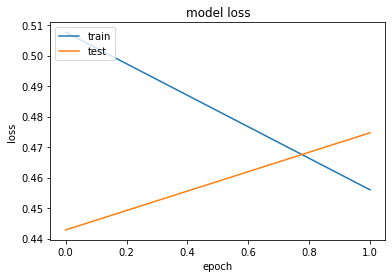

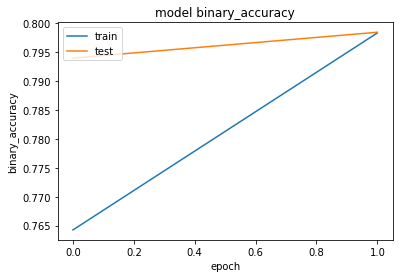

In [ ]:
def plot_history(history, list_key) :
    import matplotlib.pyplot as plt
  
    # summarize history for accuracy
    plt.plot(history.history[list_key[0]])
    plt.plot(history.history[list_key[2]])
    plt.title(f'model {list_key[0]}')
    plt.ylabel(list_key[0])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history[list_key[1]])
    plt.plot(history.history[list_key[3]])
    plt.title(f'model {list_key[1]}')
    plt.ylabel(list_key[1])
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_history(history, list(history.history.keys()))

In [ ]:
evaluate = model.evaluate([input_ids_val, attention_mask_val, token_type_ids_val], 
                                              validation.label, 
                                              verbose=0)

print('Loss score %.2f : \nAccuracy score: %.2f'%(evaluate[0], evaluate[1]))

Loss score 0.47 : 
Accuracy score: 0.80


In [ ]:
# saving model architecture and weights
 
pt_save_directory = path + "models/pt_save_pretrained"  
tokenizer.save_pretrained(pt_save_directory)
model.save_pretrained(pt_save_directory)

In [ ]:
# sauvegarde temsp d'entraînement
import pickle

with open(path + "models/bert_learning_times.pkl", "wb") as tf:
    pickle.dump(learning_time,tf)
print('Dictionnary saved!')

with open(path + "models/input_ids_test.pkl", "wb") as tf:
    pickle.dump(input_ids_test,tf)
print('Input_ids_test saved!')

with open(path + "models/attention_mask_test.pkl", "wb") as tf:
    pickle.dump(attention_mask_test,tf)
print('Attention_mask_test saved!')

with open(path + "models/token_type_ids_test.pkl", "wb") as tf:
    pickle.dump(token_type_ids_test,tf)
print('Token_type_ids_test saved!')

Dictionnary saved!
Input_ids_test saved!
Attention_mask_test saved!
Token_type_ids_test saved!


<a href="##sommaire" rev="footnote">&#8617;</a>